In [1]:
import pandas as pd
from tensorflow.keras.preprocessing import image

import tensorflow as tf

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
from tqdm import tqdm
import numpy as np

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#Augmented
df = pd.read_csv('./data/aug_HAM10000_Metadata')

In [ ]:
#Unagumented
df = pd.read_csv('./Unaug_Data/HAM10000_Metadata')

In [4]:
#Augmented
NUM_VAL = 2686
NUM_TRN = 26860 - 2686
TOTAL = 26860

In [ ]:
#Unaugmented
NUM_VAL = 1000
NUM_TRN = 10015 - 1000
TOTAL = 10015

(Warning for Sunlight, increased risk of cancer) Actinic keratoses and intraepithelial carcinoma / Bowen's disease (__akiec__), 0

(Skin cancer) basal cell carcinoma (__bcc__), 1

(HARMLESS) benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, __bkl__), 2

(HARMLESS) dermatofibroma (__df__),  3

melanoma (__mel__),  4

(Not entirely harmless) melanocytic nevi (__nv__)   5

(HARMLESS) vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, __vasc__). 6 


More than 50% of lesions are confirmed through histopathology (histo), the ground truth for the rest of the cases is either follow-up examination (follow_up), expert consensus (consensus), or confirmation by in-vivo confocal microscopy (confocal). The dataset includes lesions with multiple images, which can be tracked by the lesion_id-column within the HAM10000_metadata file.

In [5]:
df.head()

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,vidir_modern,0.0
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,vidir_modern,0.0
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,vidir_modern,0.0
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,vidir_modern,0.0
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,vidir_modern,0.0


In [6]:
df = df.sample(frac = 1).reset_index()

df.head()

,index,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,risk
0,23489,23489,HAM_0005978,aug12_ISIC_0030143,akiec,histo,65.0,female,face,rosendahl,2.0
1,21483,21483,HAM_0001337,aug6_ISIC_0032455,akiec,histo,80.0,male,upper extremity,rosendahl,2.0
2,3953,3953,HAM_0004981,ISIC_0030493,nv,follow_up,65.0,female,lower extremity,vidir_molemax,1.0
3,9652,9652,HAM_0002566,ISIC_0031105,nv,consensus,55.0,female,chest,vidir_modern,1.0
4,4299,4299,HAM_0006768,ISIC_0028284,nv,follow_up,55.0,female,lower extremity,vidir_molemax,1.0


In [7]:
df['localization'].unique()

array(['face', 'upper extremity', 'lower extremity', 'chest', 'back',
       'scalp', 'neck', 'trunk', 'abdomen', 'ear', 'foot', 'hand',
       'unknown', 'genital', 'acral'], dtype=object)

In [9]:
feature_vector = []

for i in tqdm(range(0, TOTAL)):
    sex = [1, 0, 0]
    if df.iloc[i]['sex'] == 'male':
        sex = [0, 1, 0]
    elif df.iloc[i]['sex'] == 'female':
        sex = [0, 0, 1]
        
    age = df.iloc[i]['age'] / 80
    loc = df.iloc[i]['localization']
    
    feat = np.array(sex)

    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))# - 0.5))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))# - 0.5))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))# - 0.5))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))# - 0.5))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))# - 0.5))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))# - 0.5))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))# - 0.5))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))# - 0.5))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))# - 0.5))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))# - 0.5))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))# - 0.5))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))# - 0.5))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))# - 0.5))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))# - 0.5))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))# - 0.5))

    feature_vector.append(feat)

feat_X = np.array(feature_vector)

del feature_vector

100%|██████████████████████████████████████████████████████████████████████████| 26860/26860 [00:12<00:00, 2081.29it/s]


In [ ]:
#Unagumented
risk = []

for i in range(0, 10015):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

In [10]:
np.set_printoptions(threshold=np.inf)

# 1000 Images for validation

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop_callback = EarlyStopping(
  monitor='val_accuracy', min_delta=0.001,
  patience=3, restore_best_weights=True)

In [12]:
y_trn = np.array(df['risk'])[:(-1 * NUM_VAL)]
y_val = np.array(df['risk'])[(-1 * NUM_VAL):]

# VGG model setup

In [56]:
# VGG-16
preprocessed = []

VGG_load = VGG16(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(VGG_load)
model.add(layers.Flatten())


for i in tqdm(range(0, TOTAL)):
    file = df.iloc[i]['image_id']
    feat = feat_X[i]
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    preds = model.predict(img).reshape(25088)

    preprocessed.append(np.concatenate((preds, feat)))
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
VGG_X = preprocessed

100%|████████████████████████████████████████████████████████████████████████████| 26860/26860 [15:34<00:00, 28.75it/s]


In [57]:
VGG_X_val = np.array(VGG_X)

In [58]:
VGG_X_trn = np.array(VGG_X)[:(-1 * NUM_VAL)]

VGG_X_val = np.array(VGG_X)[(-1 * NUM_VAL):]

del VGG_X

In [59]:
new_y_trn = []
for ele in y_trn:
    new_y_trn.append(np.array(tf.one_hot(ele, 4)))
    
new_y_trn = np.array(new_y_trn)

new_y_trn.shape

(24174, 4)

In [60]:
new_y_val = []
for ele in y_val:
    new_y_val.append(np.array(tf.one_hot(ele, 4)))
    
new_y_val = np.array(new_y_val)

new_y_val.shape

(2686, 4)

In [61]:
new_VGG_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_VGG_trn.append(np.array(VGG_X_trn[i]))

new_VGG_trn = np.array(new_VGG_trn)

100%|██████████████████████████████████████████████████████████████████████████| 24174/24174 [00:02<00:00, 9320.59it/s]


In [62]:
new_VGG_val = []

for i in tqdm(range(0, NUM_VAL)):
    new_VGG_val.append(np.array(VGG_X_val[i]))

new_VGG_val = np.array(new_VGG_val)

100%|████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<00:00, 5067.09it/s]


In [63]:
vgg_model = models.Sequential()
vgg_model.add(layers.Dense(8192, activation='relu'))
vgg_model.add(layers.Dense(4096, activation='relu'))
vgg_model.add(layers.Dense(2048, activation='relu'))
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dense(512, activation='relu'))
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dense(4))

In [64]:
vgg_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
vgg_model.fit(new_VGG_trn, new_y_trn, 
              epochs=30, 
              validation_data=(new_VGG_val, new_y_val), 
              callbacks=[earlystop_callback])

Epoch 1/30
756/756 [==============================] - 15s 19ms/step - loss: 0.8313 - accuracy: 0.6573 - val_loss: 0.6466 - val_accuracy: 0.7345
Epoch 2/30
756/756 [==============================] - 14s 18ms/step - loss: 0.4001 - accuracy: 0.8447 - val_loss: 0.5865 - val_accuracy: 0.7807
Epoch 3/30
756/756 [==============================] - 14s 18ms/step - loss: 0.2001 - accuracy: 0.9258 - val_loss: 0.7220 - val_accuracy: 0.7681
Epoch 4/30
756/756 [==============================] - 14s 18ms/step - loss: 0.1184 - accuracy: 0.9578 - val_loss: 0.6900 - val_accuracy: 0.8083
Epoch 5/30
756/756 [==============================] - 14s 18ms/step - loss: 0.0868 - accuracy: 0.9699 - val_loss: 0.6397 - val_accuracy: 0.8179
Epoch 6/30
756/756 [==============================] - 14s 18ms/step - loss: 0.0691 - accuracy: 0.9763 - val_loss: 0.7724 - val_accuracy: 0.8019
Epoch 7/30
756/756 [==============================] - 14s 19ms/step - loss: 0.0562 - accuracy: 0.9807 - val_loss: 0.8908 - val_accuracy:

In [ ]:
#Save vgg model
vgg_model.save("VGG_Augmented.h5")

In [65]:
predict_y_vgg_val = []
#temp_vgg_trn = vgg_model.predict(new_VGG_trn)
temp_vgg_val = vgg_model.predict(new_VGG_val)

#del new_VGG_trn
del new_VGG_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_vgg_val[i])
    predict_y_vgg_val.append(pred)

100%|██████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<00:00, 384738.08it/s]


In [ ]:
predict_vgg_std = np.array(predict_y_vgg_val).std()
predict_vgg_mean = np.array(predict_y_vgg_val).mean()

print("vgg std: ", predict_vgg_std)
print("vgg mean: " , predict_vgg_mean)

In [17]:
#Load Vgg model
vgg_model = models.load_model('VGG_Augmented.h5', compile = False)

In [ ]:
del temp_vgg_val

In [ ]:
del vgg_model

In [ ]:
del VGG_X_trn
del VGG_X_val

# ResNet setup

In [19]:
# ResNet
preprocessed = []

resnet_load = ResNet152V2(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(resnet_load)
model.add(layers.Flatten())


for i in tqdm(range(0, TOTAL)):
    file = df.iloc[i]['image_id']
    feat = feat_X[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    #img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.resnet_v2.preprocess_input(img)
    preds = model.predict(img).reshape(100352)

    preprocessed.append(np.concatenate((preds, feat)))



'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''

RES_X = preprocessed

100%|████████████████████████████████████████████████████████████████████████████| 26860/26860 [24:20<00:00, 18.39it/s]


In [ ]:
#Weight Set up
class_weights = {3:4,  1:0.3, 2:25, 0:4}

sample_weights = []

for i in range(0, 10015):
    sample_weights.append(class_weights[df.iloc[i]['risk']])
    
df['weight'] = sample_weights
sample_weights = np.array(sample_weights)
sample_weights = sample_weights[:-1000]

In [ ]:
temp_res_trn.shape

In [20]:
#RES_X_trn = np.array(RES_X)[:(-1 * NUM_VAL)]

RES_X_val = np.array(RES_X)[(-1 * NUM_VAL):]

del RES_X

In [ ]:
new_RES_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_RES_trn.append(np.array(RES_X_trn[i]))

new_RES_trn = np.array(new_RES_trn)

In [21]:
new_RES_val = []

for i in tqdm(range(0, NUM_VAL)):
    new_RES_val.append(np.array(RES_X_val[i]))

new_RES_val = np.array(new_RES_val)

100%|████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:02<00:00, 1018.22it/s]


In [ ]:
res_model = models.Sequential()
#res_model.add(layers.Dense(8192, activation='relu'))
res_model.add(layers.Dense(4096, activation='relu'))
#res_model.add(layers.Dense(2048, activation='relu'))
res_model.add(layers.Dense(1024, activation='relu'))
#res_model.add(layers.Dense(512, activation='relu'))
res_model.add(layers.Dense(128, activation='relu'))
res_model.add(layers.Dense(4))

In [ ]:
res_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
res_model.fit(new_RES_trn, new_y_trn, 
              epochs=30, callbacks=[earlystop_callback],
              validation_data=(new_RES_val, new_y_val),
             class_weight = class_weights)

In [24]:
predict_y_res_val = []
temp_res_val = res_model.predict(new_RES_val)
#temp_res_trn = res_model.predict(new_RES_trn)

#del new_RES_trn
#del new_RES_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_res_val[i])
    predict_y_res_val.append(pred)

100%|██████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<00:00, 134661.32it/s]


In [ ]:
predict_res_std = np.array(predict_y_res_val).std()
predict_res_mean = np.array(predict_y_res_val).mean()


print("res std: ", predict_res_std)
print("res mean: " , predict_res_mean)



In [22]:
res_model = models.load_model("RES_Augmentated.h5", compile = False)

# Inception V3 setup

In [ ]:
# Inception
preprocessed = []

IV3_load = InceptionV3(weights='imagenet', include_top=False)
model = models.Sequential()
model.add(IV3_load)
model.add(layers.Flatten())

for i in tqdm(range(0, TOTAL)):
    file = df.iloc[i]['image_id']
    feat = feat_X[i]
    
    #img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (299,299))
    img = image.load_img('./Unaug_Data/HAM10000_images/' + file + '.jpg', target_size= (299,299))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preds = model.predict(img).reshape(131072)

    preprocessed.append(np.concatenate((preds, feat)))


    
'''mx = 0
for i in range(0, TOTAL):
    if mx < np.amax(preprocessed[i]):
        mx = np.amax(preprocessed[i])

preprocessed = list(preprocessed / mx)
'''
IV3_X = preprocessed

In [ ]:
IV3_X_trn = np.array(IV3_X)[:(-1 * NUM_VAL)]

IV3_X_val = np.array(IV3_X)[(-1 * NUM_VAL):]

del IV3_X

In [ ]:
new_IV3_trn = []

for i in tqdm(range(0, NUM_TRN)):
    new_IV3_trn.append(np.array(IV3_X_trn[i]))

new_IV3_trn = np.array(new_IV3_trn)

new_IV3_trn.shape

In [ ]:
new_IV3_val = []

for i in tqdm(range(0, NUM_VAL)):
    new_IV3_val.append(np.array(IV3_X_val[i]))

new_IV3_val = np.array(new_IV3_val)

In [ ]:
iv3_model = models.Sequential()
#iv3_model.add(layers.Dense(8192, activation='relu'))
iv3_model.add(layers.Dense(1024, activation='relu'))
#iv3_model.add(layers.Dense(2048, activation='relu'))
iv3_model.add(layers.Dense(256, activation='relu'))
#iv3_model.add(layers.Dense(512, activation='relu'))
#iv3_model.add(layers.Dense(128, activation='relu'))
iv3_model.add(layers.Dense(4))

In [ ]:
iv3_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
iv3_model.fit(new_IV3_trn, new_y_trn, 
              epochs=30, callbacks=[earlystop_callback],
              validation_data=(new_IV3_val, new_y_val))

In [ ]:
predict_y_iv3_val = []
temp_iv3_trn = iv3_model.predict(new_IV3_trn)
temp_iv3_val = iv3_model.predict(new_IV3_val)

del new_IV3_trn
del new_IV3_val

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_iv3_val[i])
    predict_y_iv3_val.append(pred)

# Making the confusion matrices

In [ ]:
cm_iv3 = tf.math.confusion_matrix(np.array(df['risk'])[(-1 * NUM_VAL):], np.array(predict_y_iv3_val))

In [66]:
cm_vgg = tf.math.confusion_matrix(np.array(df['risk'])[(-1 * NUM_VAL):], np.array(predict_y_vgg_val))

In [50]:
cm_res = tf.math.confusion_matrix(np.array(df['risk'])[(-1 * NUM_VAL):], np.array(predict_y_res_val))

In [67]:
#cm_iv3 = np.array(cm_iv3).astype('float32')
cm_vgg = np.array(cm_vgg).astype('float32')
#cm_res = np.array(cm_res).astype('float32')

In [ ]:
cm_iv3[0] = cm_iv3[0] / (1.0 * cm_iv3[0].sum())
cm_iv3[1] = cm_iv3[1] / (1.0 * cm_iv3[1].sum())
cm_iv3[2] = cm_iv3[2] / (1.0 * cm_iv3[2].sum())
cm_iv3[3] = cm_iv3[3] / (1.0 * cm_iv3[3].sum())


In [68]:

cm_vgg[0] = cm_vgg[0] / (1.0 * cm_vgg[0].sum())
cm_vgg[1] = cm_vgg[1] / (1.0 * cm_vgg[1].sum())
cm_vgg[2] = cm_vgg[2] / (1.0 * cm_vgg[2].sum())
cm_vgg[3] = cm_vgg[3] / (1.0 * cm_vgg[3].sum())

In [53]:


cm_res[0] = cm_res[0] / (1.0 * cm_res[0].sum())
cm_res[1] = cm_res[1] / (1.0 * cm_res[1].sum())
cm_res[2] = cm_res[2] / (1.0 * cm_res[2].sum())
cm_res[3] = cm_res[3] / (1.0 * cm_res[3].sum())

In [47]:
import seaborn as sns

#sns.heatmap(cm_iv3, annot=True)

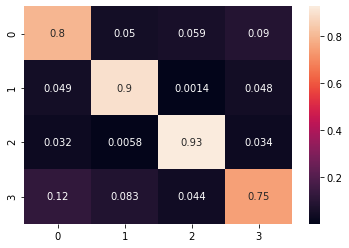

In [69]:
sns.heatmap(cm_vgg, annot=True);

<AxesSubplot:>

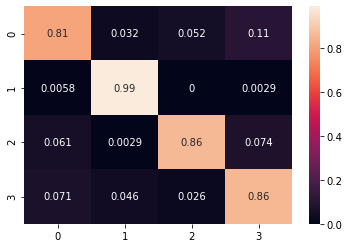

In [55]:
sns.heatmap(cm_res, annot=True)

# Stacking the models

In [ ]:
"""max_iv3,"""
max_vgg, max_res = 0, 0


#max_iv3 = np.amax([np.amax(temp_iv3_trn), np.amax(temp_iv3_val)])
max_vgg = np.amax([np.amax(temp_vgg_trn), np.amax(temp_vgg_val)])
max_res = np.amax([np.amax(temp_res_trn), np.amax(temp_res_val)])

In [ ]:
new_X_trn = []

for i in tqdm(range(0, NUM_TRN)):
    feat = np.concatenate(( #(temp_iv3_trn[i] / max_iv3), 
                            (temp_vgg_trn[i] / max_vgg), 
                            (temp_res_trn[i] / max_res) ))
    new_X_trn.append(feat)
    
new_X_trn = np.array(new_X_trn)
new_X_trn.shape

In [ ]:
new_X_val = []

for i in tqdm(range(0, NUM_VAL)):
    feat = np.concatenate(( #(temp_iv3_val[i]), 
                            (temp_vgg_val[i]/max_vgg), 
                            (temp_res_val[i]/max_res)))
    new_X_val.append(feat)
    
new_X_val = np.array(new_X_val)
new_X_val.shape

In [ ]:
final_model = models.Sequential()

#final_model.add(layers.Dense(64, activation='relu'))
#final_model.add(layers.Dense(32, activation='relu'))
#final_model.add(layers.Dense(16, activation='relu'))
#final_model.add(layers.Dense(8, activation='relu'))
final_model.add(layers.Dense(4))

In [ ]:
final_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
final_model.fit(new_X_trn, new_y_trn, 
                epochs=20, callbacks=[earlystop_callback],
                validation_data=(new_X_val, new_y_val))

In [ ]:
predict_y_final_val = []
temp_final_val = final_model.predict(new_X_val)

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_final_val[i])
    predict_y_final_val.append(pred)

In [73]:
cm_final = tf.math.confusion_matrix(np.array(df['risk'])[(-1 * NUM_VAL):], np.array(predict_y_final_val))

cm_final = np.array(cm_final).astype('float32')

cm_final[0] = cm_final[0] / (1.0 * cm_final[0].sum())
cm_final[1] = cm_final[1] / (1.0 * cm_final[1].sum())
cm_final[2] = cm_final[2] / (1.0 * cm_final[2].sum())
cm_final[3] = cm_final[3] / (1.0 * cm_final[3].sum())

<AxesSubplot:>

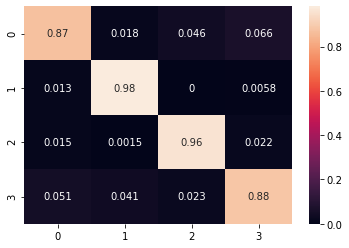

In [74]:
sns.heatmap(cm_final, annot=True)

In [25]:
temp_vgg_val

array([[ 2.13714671e+00,  1.49563770e+01, -5.78638315e+00,
        -1.40659499e+00],
       [-2.84972167e+00, -2.00825524e+00,  1.38353863e+01,
        -3.76878917e-01],
       [ 3.36841178e+00, -1.47761568e-01, -1.53389323e+00,
        -6.08280241e-01],
       [ 6.43447399e+00, -4.22797060e+00, -4.35360479e+00,
         1.12096930e+00],
       [ 7.94967711e-01, -5.49874687e+00,  1.22362747e+01,
        -2.63606340e-01],
       [-1.04201043e+00,  1.35518599e+01, -2.25247669e+00,
         5.59251048e-02],
       [ 3.21638012e+00, -4.28309727e+00, -1.34547698e+00,
         1.80585802e+00],
       [-2.03040075e+00, -1.54148757e+00,  9.93052006e+00,
         3.49660635e-01],
       [ 4.82609093e-01, -3.67327595e+00, -5.29944372e+00,
         7.90895367e+00],
       [ 7.10493183e+00, -6.96848631e+00, -1.24185324e+00,
         9.63072062e-01],
       [ 1.22096767e+01, -5.09091568e+00, -4.55190754e+00,
        -2.31847739e+00],
       [-2.39589453e+00,  6.01385641e+00, -1.28939116e+00,
      

In [32]:
temp_res_val

array([[-3.44939852e+00,  5.29022503e+00, -2.19573917e+01,
         5.93343735e-01],
       [ 1.38730946e+01, -1.37453594e+01,  3.11728935e+01,
         4.70544672e+00],
       [ 1.07694807e+01, -2.88049841e+00, -3.04663420e-01,
         2.26028228e+00],
       [ 2.34823990e+01, -3.80090523e+00, -5.11144924e+00,
         3.28066349e+00],
       [ 9.24815178e+00, -1.36769218e+01,  1.96672783e+01,
         7.55536747e+00],
       [-8.11845899e-01,  1.06014853e+01, -2.05805264e+01,
        -5.62768888e+00],
       [ 1.53089647e+01, -1.29009449e+00, -2.49808860e+00,
        -7.60649800e-01],
       [ 1.14981902e+00, -2.85451531e+00, -3.56267834e+00,
         2.02447176e+00],
       [-2.36192942e+00, -4.73379660e+00, -1.56195087e+01,
         7.54478645e+00],
       [ 8.68661404e+00, -9.39463043e+00,  2.74284625e+00,
         6.97728825e+00],
       [ 2.56409492e+01, -4.39826536e+00, -1.76986523e+01,
        -5.03571129e+00],
       [-1.83168876e+00,  6.42508698e+00, -2.10891533e+01,
      

In [ ]:
#Average total vgg+res

In [70]:
temp_all = []
for i in range(0, NUM_VAL):
    temp_all.append((temp_res_val[i]+temp_vgg_val[i])/2)
temp_all = np.array(temp_all)

In [71]:
predict_y_final_val = []

for i in tqdm(range(0, NUM_VAL)):
    pred = np.argmax(temp_all[i])
    predict_y_final_val.append(pred)

100%|██████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<00:00, 358809.50it/s]


In [72]:
predict_y_final_val

[1,
 2,
 0,
 0,
 2,
 1,
 0,
 2,
 3,
 0,
 0,
 1,
 2,
 3,
 1,
 1,
 3,
 1,
 2,
 2,
 2,
 3,
 2,
 0,
 0,
 2,
 0,
 1,
 3,
 1,
 0,
 2,
 2,
 0,
 3,
 0,
 2,
 1,
 1,
 1,
 0,
 3,
 3,
 3,
 2,
 3,
 2,
 1,
 0,
 0,
 3,
 1,
 2,
 0,
 3,
 3,
 1,
 1,
 1,
 3,
 0,
 3,
 2,
 0,
 0,
 3,
 1,
 3,
 2,
 3,
 3,
 3,
 3,
 2,
 0,
 1,
 0,
 3,
 1,
 2,
 3,
 0,
 2,
 3,
 0,
 1,
 3,
 2,
 2,
 3,
 3,
 0,
 2,
 0,
 0,
 0,
 0,
 1,
 1,
 2,
 0,
 0,
 2,
 3,
 1,
 1,
 2,
 1,
 0,
 0,
 3,
 2,
 3,
 1,
 2,
 2,
 2,
 1,
 1,
 3,
 2,
 3,
 2,
 2,
 1,
 2,
 2,
 3,
 1,
 1,
 2,
 1,
 1,
 3,
 0,
 2,
 1,
 0,
 3,
 3,
 2,
 0,
 2,
 1,
 3,
 2,
 1,
 0,
 0,
 2,
 2,
 1,
 2,
 3,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 0,
 0,
 0,
 3,
 1,
 2,
 3,
 1,
 1,
 0,
 1,
 2,
 2,
 0,
 1,
 2,
 1,
 0,
 3,
 1,
 1,
 2,
 0,
 3,
 3,
 1,
 2,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 3,
 3,
 2,
 0,
 1,
 2,
 1,
 2,
 0,
 2,
 1,
 1,
 3,
 2,
 0,
 3,
 1,
 2,
 3,
 3,
 2,
 1,
 1,
 3,
 3,
 1,
 0,
 3,
 3,
 2,
 2,
 2,
 1,
 1,
 3,
 3,
 2,
 0,
 2,
 2,
 2,
 3,
 2,
 0,
 0,
 0,
 1,


In [ ]:
for i 

# New Original Model

In [ ]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [ ]:
df = df.sample(frac = 1).reset_index()

df.head()

In [ ]:
risk = []

for i in range(0, TOTAL):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append(0.0)
    elif df.iloc[i]['dx'] == 'nv':
        risk.append(1.0)
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append(2.0)
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append(3.0)
        
df['risk'] = risk

df.head()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
fig, axs = plt.subplots(4,1, figsize=(15,30), sharex=True)

sns.histplot(x='localization', data=df[df['risk'] == 0.0], color='green', stat='probability', ax=axs[0]).set_title('risk 0')
sns.histplot(x='localization', data=df[df['risk'] == 1.0], color='yellow', stat='probability', ax=axs[1]).set_title('risk 1')
sns.histplot(x='localization', data=df[df['risk'] == 2.0], color='orange', stat='probability', ax=axs[2]).set_title('risk 2')
sns.histplot(x='localization', data=df[df['risk'] == 3.0], color='red', stat='probability', ax=axs[3]).set_title('risk 3')

In [ ]:
X = []

for i in tqdm(range(0, TOTAL)):
    file = df.iloc[i]['image_id']
    
    img = image.load_img('./Data/HAM10000_images/' + file + '.jpg', target_size= (150,200))
    img = image.img_to_array(img) / 255.0
    
    
    X.append(img)

In [ ]:
X = np.array(X)

X.shape

In [ ]:
risk = []

for ele in df['risk']:
    risk.append(tf.one_hot(int(ele), 4))
    
y = np.array(risk)
y.shape

In [ ]:
ori_model = models.Sequential()
ori_model.add(layers.Conv2D(64, (3, 3), activation='tanh', input_shape=(150,200,3)))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(32, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Conv2D(16, (3, 3), activation='tanh'))
ori_model.add(layers.BatchNormalization())
ori_model.add(layers.Activation(activations.elu))
ori_model.add(layers.MaxPooling2D(2,2))


ori_model.add(layers.Flatten(name="feature_output"))

ori_model.add(layers.Dense(1024, activation='relu'))
ori_model.add(layers.Dense(256, activation='relu'))
ori_model.add(layers.Dense(64, activation='relu'))
ori_model.add(layers.Dense(4))

In [ ]:
ori_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
ori_model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16)

In [ ]:
ori_model.save('./models/feature')

In [ ]:
loaded_model = tf.keras.models.load_model("./models/feature")


feature_extractor = tf.keras.Model(
    inputs=loaded_model.inputs,
    outputs=loaded_model.get_layer(name="feature_output").output,
)

In [ ]:
feature_vector = []

for i in tqdm(range(0, TOTAL)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)

In [ ]:
feature_vector = np.array(feature_vector)

In [ ]:
feature_vector.shape

In [ ]:
image_features = feature_extractor(X)

In [ ]:
X = []
for img_feat, feat in zip(image_features, feature_vector):
    X.append(np.concatenate((img_feat, feat)))

X = np.array(X)

In [ ]:
model = models.Sequential()

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(4))

In [ ]:
model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
model.fit(X, y, epochs=25, validation_split=0.1, batch_size=16, sample_weight=sample_weights)

In [ ]:
df = pd.read_csv('./data/HAM10000_Metadata')

In [ ]:
df = df.sample(frac = 1).reset_index()

df.head()

In [ ]:
risk = []

for i in range(0, TOTAL):
    if df.iloc[i]['dx'] in ['bkl', 'df', 'vasc']:
        risk.append('no')
    elif df.iloc[i]['dx'] == 'nv':
        risk.append('lo')
    elif df.iloc[i]['dx'] == 'akiec':
        risk.append('md')
    elif df.iloc[i]['dx'] in ['mel', 'bcc']:
        risk.append('hi')
        
df['risk'] = risk

df.head()

In [ ]:
df['image_id'] = df['image_id'].apply(lambda x: x + '.jpg')

df.head()

In [ ]:
# VGG-16
VGG_load = VGG16(weights='imagenet')

model = models.Sequential()
model.add(VGG_load)
model.add(layers.Dense(4))

In [ ]:
data_gen = ImageDataGenerator(
    rotation_range=90, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    horizontal_flip=True, preprocessing_function = tf.keras.applications.vgg16.preprocess_input,
    vertical_flip=True, validation_split=0.1, zoom_range=0.3)

In [ ]:
df['risk'].value_counts()

In [ ]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training').class_indices

In [ ]:
data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation').class_indices

In [ ]:
class_weights = {'hi':1, 'lo':0.25, 'md':5, 'no':1}

In [ ]:
sample_weights = []

for i in range(0, TOTAL):
    sample_weights.append(class_weights[df.iloc[i]['risk']])
    
df['weight'] = sample_weights

df.head()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])

model.fit(
    x=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='training'),
    validation_data=data_gen.flow_from_dataframe(df, directory='./data/HAM10000_images', weight_col='weight',
                                          x_col='image_id', y_col='risk', target_size=(224,224),
                                          subset='validation'),
    epochs=50)

In [ ]:
feature_vector = []

for i in tqdm(range(0, TOTAL)):
    sex = 0 if df.iloc[i]['sex'] == 'male' else 1
    age = df.iloc[i]['age']
    loc = df.iloc[i]['localization']
    
    feat = np.array([sex, age])
    
    if loc == 'abdomen':
        feat = np.concatenate((feat, tf.one_hot(0, 15)))
    elif loc == 'scalp':
        feat = np.concatenate((feat, tf.one_hot(1, 15)))
    elif loc == 'lower extremity':
        feat = np.concatenate((feat, tf.one_hot(2, 15)))
    elif loc == 'trunk':
        feat = np.concatenate((feat, tf.one_hot(3, 15)))
    elif loc == 'upper extremity':
        feat = np.concatenate((feat, tf.one_hot(4, 15)))
    elif loc == 'back':
        feat = np.concatenate((feat,tf.one_hot(5, 15)))
    elif loc == 'neck':
        feat = np.concatenate((feat,tf.one_hot(6, 15)))
    elif loc == 'face':
        feat = np.concatenate((feat,tf.one_hot(7, 15)))
    elif loc == 'chest':
        feat = np.concatenate((feat,tf.one_hot(8, 15)))
    elif loc == 'foot':
        feat = np.concatenate((feat,tf.one_hot(9, 15)))
    elif loc == 'ear':
        feat = np.concatenate((feat,tf.one_hot(10, 15)))
    elif loc == 'unknown':
        feat = np.concatenate((feat,tf.one_hot(11, 15)))
    elif loc == 'hand':
        feat = np.concatenate((feat,tf.one_hot(12, 15)))
    elif loc == 'acral':
        feat = np.concatenate((feat,tf.one_hot(13, 15)))
    elif loc == 'genital':
        feat = np.concatenate((feat,tf.one_hot(14, 15)))

    feature_vector.append(feat)
feature_vector = np.array(feature_vector)

feature_vector.shape

In [ ]:
unique, counts = np.unique(feature_vector, return_counts=True, axis=1)

In [ ]:
unique

In [ ]:
feature_extractor = tf.keras.Model(
    inputs=VGG_load.inputs,
    outputs=VGG_load.layers[-4].output,
)

In [ ]:
preprocessed = []

for i in tqdm(range(0, TOTAL)):
    file = df.iloc[i]['image_id']
    feat_vec = feature_vector[i]    
    
    img = image.load_img('./Data/HAM10000_images/' + file, target_size= (224,224))
    img = image.img_to_array(img)
    # img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.vgg16.preprocess_input(img)
    img_feat = feature_extractor(img)

    preprocessed.append(np.concatenate((img_feat, feat_vec)))
    
preprocessed = np.array(preprocessed)

In [ ]:
ohr = []

for i in range(0, TOTAL):
    risk = df.iloc[i]['risk']
    
    if risk == 'no':
        ohr.append(tf.one_hot(0, 4))
    elif risk == 'lo':
        ohr.append(tf.one_hot(1, 4))
    elif risk == 'md':
        ohr.append(tf.one_hot(2, 4))
    elif risk == 'hi':
        ohr.append(tf.one_hot(3, 4))
        
ohr = np.array(ohr)

ohr.shape

In [ ]:
ohr

In [ ]:
new_model = models.Sequential()
new_model.add(layers.Dense(4096, activation='relu'))
new_model.add(layers.Dense(2048, activation='relu'))
new_model.add(layers.Dense(512, activation='relu'))
new_model.add(layers.Dense(128, activation='relu'))
new_model.add(layers.Dense(4))

In [ ]:
new_model.compile(optimizer='Adam',
              loss=tf.nn.softmax_cross_entropy_with_logits,
              metrics=['accuracy'])
new_model.fit(preprocessed, ohr, sample_weight=np.array(df['weight']), epochs=10, validation_split=0.1)